In [39]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Loading dataset
df = pd.read_csv('../data/AB7_ENG_Release_Version6.csv')

In [41]:
df.head(3)

,COUNTRY,ID,DATE,Q1,PSU,Q13,Q1A_PAL,Q1A_ALG,Q1A_LIB,WT,...,Q1010D_1,Q1010D_2,Q1010B1,Q1010B2,Q1014A,Q1014B,Q1014C,Q1015,Q1015A,Q1016
0,21,210001,2021-10-16,210009,134,2.0,NaN,NaN,NaN,1.311519,...,NaN,NaN,NaN,NaN,1.0,0.0,8.0,350.0,NaN,3.0
1,21,210002,2021-10-25,210018,256,2.0,NaN,NaN,NaN,0.441604,...,NaN,NaN,1.0,4.0,0.0,0.0,6.0,1500.0,NaN,3.0
2,21,210003,2021-11-10,210007,111,1.0,NaN,NaN,NaN,1.694783,...,NaN,NaN,1.0,2.0,2.0,0.0,5.0,400.0,NaN,3.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26154 entries, 0 to 26153
Columns: 453 entries, COUNTRY to Q1016
dtypes: float64(445), int64(7), object(1)
memory usage: 90.4+ MB


In [43]:
df.describe()

,COUNTRY,ID,Q1,PSU,Q13,Q1A_PAL,Q1A_ALG,Q1A_LIB,WT,Q1001,...,Q1010D_1,Q1010D_2,Q1010B1,Q1010B2,Q1014A,Q1014B,Q1014C,Q1015,Q1015A,Q1016
count,26154.000000,26154.000000,26154.000000,2.615400e+04,24926.000000,1800.000000,2162.000000,2505.000000,26154.000000,26154.000000,...,10703.000000,10690.000000,17812.000000,15934.000000,26148.000000,26140.000000,26150.000000,2.615200e+04,6219.000000,26145.000000
mean,11.040376,111522.886939,100931.538120,4.227239e+05,1.373546,1.341667,2.951896,1102.399202,0.999709,1957.418024,...,5.643184,37.442563,1.154053,3.540479,4.772334,4.540742,7.046004,2.451469e+08,28.703972,4.089730
std,5.492637,54951.303605,62235.173958,1.903919e+06,0.511803,0.474400,1.008294,0.875382,0.649241,13715.450998,...,20.184785,46.400633,2.221208,4.261294,309.406108,19.287420,12.638073,4.294917e+08,43.519260,11.429022
min,1.000000,10001.000000,10001.000000,1.000000e+00,1.000000,1.000000,1.000000,1101.000000,0.026650,18.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,7.000000,72333.250000,50025.000000,6.800000e+01,1.000000,1.000000,2.000000,1101.000000,0.562336,27.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,4.000000,1.800000e+03,1.000000,2.000000
50%,11.000000,110385.500000,100002.000000,1.400000e+02,1.000000,1.000000,3.000000,1103.000000,0.858000,37.000000,...,1.000000,2.000000,1.000000,3.000000,1.000000,0.000000,6.000000,4.500000e+04,2.000000,3.000000
75%,15.000000,150014.750000,150001.000000,2.180000e+02,2.000000,2.000000,4.000000,1103.000000,1.261000,50.000000,...,1.000000,97.000000,1.000000,4.000000,3.000000,1.000000,7.000000,1.500000e+07,98.000000,3.000000
max,21.000000,212400.000000,210024.000000,9.000607e+06,3.000000,2.000000,5.000000,1103.000000,5.301769,99999.000000,...,99.000000,99.000000,99.000000,99.000000,50000.000000,99.000000,998.000000,1.000000e+09,99.000000,99.000000


In [44]:
df.shape

(26154, 453)

In [45]:
# Dictionnaire de mapping pour les colonnes principales
column_mapping = {
    # Variables d'échantillonnage
    'COUNTRY': 'Country',
    'ID': 'Respondent_ID',
    'DATE': 'Interview_Date',
    'Q1': 'Governorate',
    'PSU': 'Primary_Sampling_Unit',
    'Q13': 'Settlement_Type',
    'Q1A_PAL': 'Palestine_Area',
    'Q1A_ALG': 'Algeria_Region',
    'Q1A_LIB': 'Libya_Region',
    'WT': 'Weight',
    
    # Démographie de base
    'Q1001': 'Age',
    'Q1001YEAR': 'Birth_Year',
    'Q1001APPROX': 'Approximate_Age',
    'Q1002': 'Gender',
    
    # COVID-19
    'Q2061A': 'Most_Important_Challenge_Country',
    'Q2061A_KUW': 'Most_Important_Challenge_Kuwait',
    'Q1COVID19': 'Fear_COVID_Spread',
    'Q2ACOVID19': 'Reason_Concerned_COVID',
    'Q2BCOVID19': 'Reason_Not_Concerned_COVID',
    'Q16ACOVID19_1': 'COVID_Relief_None',
    'Q16ACOVID19_2': 'COVID_Relief_Money',
    'Q16ACOVID19_3': 'COVID_Relief_Food',
    'Q16ACOVID19_4': 'COVID_Relief_Energy_Subsidies',
    'Q16ACOVID19_5': 'COVID_Relief_Non_Food_Items',
    'Q16ACOVID19_6': 'COVID_Relief_Utility_Bills_Grace',
    'Q16ACOVID19_7': 'COVID_Relief_Tax_Grace',
    'Q16ACOVID19_8': 'COVID_Relief_Other',
    'Q16BCOVID19_1': 'COVID_Aid_Source_National_Govt',
    'Q16BCOVID19_2': 'COVID_Aid_Source_Local_Govt',
    'Q16BCOVID19_3': 'COVID_Aid_Source_Local_NGO',
    'Q16BCOVID19_4': 'COVID_Aid_Source_Intl_NGO',
    'Q16BCOVID19_5': 'COVID_Aid_Source_Religious',
    'Q16BCOVID19_6': 'COVID_Aid_Source_Family_Friends',
    'Q16BCOVID19_7': 'COVID_Aid_Source_Charities',
    'Q16BCOVID19_8': 'COVID_Aid_Source_Other',
    'Q15COVID19_1': 'COVID_Challenge_First',
    'Q15COVID19_2': 'COVID_Challenge_Second',
    'Q12COVID19_3': 'COVID_Impact_Poor_Citizens',
    'Q12COVID19_4': 'COVID_Impact_Rural_Citizens',
    'Q12COVID19_4MOR': 'COVID_Impact_Mountain_Citizens_Morocco',
    'Q12COVID19_5A': 'COVID_Impact_Refugees',
    'Q12COVID19_5B': 'COVID_Impact_Migrants',
    'Q204_25': 'Govt_Performance_COVID_Response',
    'Q18ACOVID19': 'Healthcare_System_Weakness',
    'Q17COVID19': 'Vaccinated_COVID',
    'Q18COVID19': 'Likelihood_Get_Vaccine',
    'Q19COVID19_1': 'Vaccine_Preference_No_Preference',
    'Q19COVID19_2': 'Vaccine_Preference_Pfizer',
    'Q19COVID19_3': 'Vaccine_Preference_JJ',
    'Q19COVID19_4': 'Vaccine_Preference_Moderna',
    'Q19COVID19_5': 'Vaccine_Preference_AstraZeneca',
    'Q19COVID19_6': 'Vaccine_Preference_Coronavac',
    'Q19COVID19_7': 'Vaccine_Preference_Sputnik',
    'Q19COVID19_8': 'Vaccine_Preference_Sinopharm',
    'Q19COVID19_9': 'Vaccine_Preference_USA_Developed',
    'Q19COVID19_10': 'Vaccine_Preference_Russia_Developed',
    'Q19COVID19_11': 'Vaccine_Preference_China_Developed',
    'Q19COVID19_12': 'Vaccine_Preference_UK_Developed',
    'Q19COVID19_13': 'Vaccine_Preference_Other_Country',
    'Q20COVID19': 'Reason_Not_Get_Vaccine',
    
    # Économie
    'Q101': 'Current_Economic_Situation',
    'Q102': 'Future_Economic_Situation',
    'Q113': 'Rich_Poor_Gap_Problem',
    'Q114': 'Rich_Poor_Gap_Change',
    'Q115_1': 'Inequality_Work_Harder',
    'Q115_4': 'Inequality_Born_Wealth',
    'Q115_6': 'Inequality_Govt_Not_Fighting',
    'Q112_1': 'Food_Insecurity_Worried',
    'Q112_2': 'Food_Insecurity_Not_Last',
    'Q118_1': 'Govt_Economic_Priority_First',
    'Q118_2': 'Govt_Economic_Priority_Second',
    'Q119': 'Jobs_Public_Private_Sector',
    'Q122_1': 'Sector_Harder_Get_Job',
    'Q122_2': 'Sector_Better_Salaries',
    'Q122_3': 'Sector_More_Stability',
    'Q122_6': 'Sector_More_Wasta',
    'Q122_9': 'Sector_Preferable_Job',
    'Q124': 'Interest_Starting_Business_Morocco',
    'Q123': 'Govt_Spending_Priority',
    'Q123_EGY': 'Govt_Spending_Priority_Egypt',
    'Q123_KUW': 'Govt_Spending_Priority_Kuwait',
    
    # Confiance et performance gouvernementale
    'Q103': 'Trust_Most_People',
    'Q201A_1': 'Trust_Government',
    'Q201A_2': 'Trust_Courts_Legal',
    'Q201A_3': 'Trust_Parliament',
    'Q201A_5': 'Trust_Local_Govt',
    'Q201A_41': 'Trust_Regional_Govt',
    'Q201A_7': 'Trust_Civil_Society',
    'Q201A_31B': 'Trust_President',
    'Q201A_31C': 'Trust_Prime_Minister',
    'Q201B_6': 'Trust_Armed_Forces',
    'Q201B_13': 'Trust_Religious_Leaders',
    'Q201B_12': 'Trust_Islamist_Party',
    'Q201B_15': 'Trust_Tribal_Leaders',
    'Q204A_3': 'Satisfaction_Govt_Performance',
    'Q204A_1': 'Satisfaction_Education_System',
    'Q204A_1B': 'Satisfaction_Public_Education',
    'Q204A_2': 'Satisfaction_Healthcare_System',
    'Q204A_4': 'Satisfaction_Streets_Quality',
    'Q204A_5': 'Satisfaction_Trash_Collection',
    'Q914A_1': 'Public_School_Challenge_First',
    'Q914A_2': 'Public_School_Challenge_Second',
    'Q915A': 'Ministry_Education_Priority',
    'Q216': 'Support_Govt_Decisions',
    'Q204_3': 'Govt_Performance_Rich_Poor_Gap',
    'Q204_11': 'Govt_Performance_Security_Order',
    'Q204_20': 'Govt_Performance_Prices',
    'Q273A': 'Most_Effective_Influence_Govt',
    'Q273B': 'Least_Effective_Influence_Govt',
    'Q210': 'Corruption_State_Agencies',
    'Q211_1': 'Govt_Crackdown_Corruption',
    'Q211B': 'Corruption_Local_Govt',
    'Q213A_2A': 'Corrupt_Govt_Job_Relative',
    'Q213A_2B': 'Corrupt_Business_Job_Relative',
    'Q274A': 'Electricity_Outages_Frequency',
    'Q274C': 'Alternative_Electricity_Source',
    'Q274B': 'Water_Outages_Frequency',
    'Q275': 'System_Needs_Change',
    'Q276': 'Govt_Responsiveness',
    
    # Engagement et préférences de gouvernance
    'Q404': 'Interest_Politics',
    'Q501': 'Member_Organization',
    'Q501B_1': 'Org_Type_Civic',
    'Q501B_2': 'Org_Type_Religious',
    'Q501B_3': 'Org_Type_Other',
    'Q501D': 'Volunteer_Work',
    'Q501E_2': 'Volunteer_Cause_Type',
    'Q266': 'Donate_Money_Charity',
    'Q263': 'Preference_Help_Poor',
    'Q537': 'Role_Model',
    'Q542': 'Online_Activity_Community',
    'Q543_2': 'Online_Activity_Problem_Type',
    'Q545': 'Online_Activity_Goal',
    'Q532A': 'Protest_Participation',
    'Q538_2': 'Reuse_Bottles_Frequency',
    'Q539_2': 'Reason_Reuse_Bottles',
    'Q540_1': 'Environmental_Challenge_First',
    'Q540_2': 'Environmental_Challenge_Second',
    'Q541_1': 'Environment_Lack_Awareness',
    'Q541_2': 'Environment_Lack_Govt_Spending',
    'Q546': 'Govt_Action_Climate_Change',
    'Q521_1': 'Freedom_Express_Opinion',
    'Q521_4': 'Freedom_Peaceful_Protest',
    'Q521_2A': 'Freedom_Media_Criticize_Govt',
    'Q521_2B': 'Freedom_Press',
    'Q521_6': 'Freedom_Religion',
    'Q536_2': 'Justifiable_Limit_Speech',
    'Q536_4': 'Justifiable_Censor_Media',
    'Q516A': 'Democracy_Preference',
    'Q514A': 'Political_Reform_Pace',
    'Q516_1': 'Democracy_Weak_Economy',
    'Q516_2': 'Democracy_Indecisive',
    'Q516_3': 'Democracy_Not_Maintain_Order',
    'Q516_4': 'Democracy_Better_Despite_Problems',
    'Q533_3': 'Govt_Solve_Economic_Problem',
    'Q533_4': 'Leader_Bend_Rules',
    'Q533_5': 'Maintain_Order_Democracy',
    'Q301A': 'Voted_Last_Election',
    'Q301B': 'Intend_Vote_Libya',
    'Q303A': 'Election_Free_Fair',
    'Q301C': 'Voted_Local_Election',
    'Q503A_1': 'Political_Party_Closest',
    
    # Migration
    'Q104': 'Thought_Emigrating',
    'Q104A_2_1': 'Emigrate_Economic_Reasons',
    'Q104A_2_2': 'Emigrate_Political_Reasons',
    'Q104A_2_3': 'Emigrate_Religious_Reasons',
    'Q104A_2_4': 'Emigrate_Security_Reasons',
    'Q104A_2_5': 'Emigrate_Education',
    'Q104A_2_6': 'Emigrate_Family_Reunion',
    'Q104A_2_7': 'Emigrate_Corruption',
    'Q104A_2_8': 'Emigrate_Other_Reasons',
    'Q104B_1': 'Emigrate_To_Saudi_Arabia',
    'Q104B_2': 'Emigrate_To_UAE',
    'Q104B_3': 'Emigrate_To_Qatar',
    'Q104B_14': 'Emigrate_To_USA',
    'Q104B_15': 'Emigrate_To_Canada',
    'Q104B_18': 'Emigrate_To_France',
    'Q104B_19': 'Emigrate_To_Germany',
    'Q104C': 'Emigrate_Without_Papers',
    'Q1017': 'Receive_Remittances',
    'Q905': 'Discrimination_SubSaharan_Migrants',
    
    # Identité et pratique religieuse
    'Q861': 'Offended_Western_Disrespect',
    'Q862': 'Offended_Arab_Disrespect',
    'Q870A_2': 'Group_Discrimination_Lower_Class',
    'Q870B_2': 'Group_Discrimination_Healthcare',
    'Q871_1': 'Discriminated_Group_Govt_Treatment',
    'Q871_3': 'Discriminated_Group_Society_Treatment',
    'Q872': 'Racial_Discrimination_Problem',
    'Q873A': 'Dark_Skinned_Discrimination',
    'Q873B': 'Black_People_Discrimination',
    'Q874': 'Experienced_Racist_Phrase',
    'Q875_1': 'Response_Racism_Physical',
    'Q875_2': 'Response_Racism_Verbal',
    'Q875_3': 'Response_Racism_Ask_Intervention',
    'Q875_4': 'Response_Racism_Report_Authority',
    'Q875_5': 'Response_Racism_Ignored',
    'Q876': 'Black_People_TV_Representation',
    'Q877': 'Prefer_More_Black_People_TV',
    'Q1012': 'Religion',
    'Q1012A_MUSLIM': 'Muslim_Denomination',
    'Q1012A_CHRISTIAN': 'Christian_Denomination',
    'Q1020JO': 'Country_Origin_Jordan',
    'Q1012B': 'Ethnicity',
    'Q609': 'Religious_Self_Description',
    'Q610_1': 'Pray_Daily_Frequency',
    'Q610_8': 'Pray_Fajr_On_Time',
    'Q610_6A': 'Read_Quran_Daily',
    'Q610_6B': 'Read_Bible_Daily',
    'Q606_2': 'Religious_People_Public_Positions',
    'Q606_3': 'Religious_Clerics_Influence_Govt',
    'Q606_4': 'Religious_Practice_Private',
    'Q606_8': 'Religious_Leaders_Corrupt',
    'Q605': 'Laws_Based_Sharia',
    'Q868': 'Religion_Teaching_Schools',
    'Q867A': 'Quality_Life_Vs_Parents',
    'Q867B': 'Quality_Life_Children_Future',
    
    # Normes et attitudes de genre
    'Q601_3': 'Men_Better_Political_Leadership',
    'Q601_4': 'University_More_Important_Males',
    'Q601_18': 'Man_Final_Say_Family',
    'Q601_20A': 'Woman_Pass_Citizenship',
    'Q621_1': 'Workplace_Barrier_Transportation',
    'Q621_2': 'Workplace_Barrier_Lacking_Skills',
    'Q621_3A': 'Workplace_Barrier_Gender_Mix',
    'Q622A': 'Biggest_Workplace_Barrier_Women',
    'Q622B': 'Biggest_Workplace_Barrier_Men',
    'Q624_1': 'Household_Responsible_Help_Children_Study',
    'Q624_2': 'Household_Responsible_Budgeting',
    'Q620': 'Gender_Separation_Workplace',
    'Q620A_1': 'Separation_Reason_Uncomfortable',
    'Q620A_2': 'Separation_Reason_Hadith',
    'Q620A_3': 'Separation_Reason_Shameful',
    'Q620A_4': 'Separation_Reason_Distracted',
    'Q620A_5': 'Separation_Reason_Reputation',
    'Q620A_6': 'Separation_Reason_Harassment',
    'Q620A_7': 'Separation_Reason_Empower_Women',
    'Q625': 'Violence_Against_Women_Change',
    
    # Médias
    'Q409': 'Internet_Usage_Frequency',
    'Q424': 'Social_Media_Hours_Daily',
    'Q412A_1': 'Social_Media_Facebook',
    'Q412A_2': 'Social_Media_Twitter',
    'Q412A_3': 'Social_Media_Instagram',
    'Q412A_4': 'Social_Media_YouTube',
    'Q412A_5': 'Social_Media_WhatsApp',
    'Q412A_6': 'Social_Media_Telegram',
    'Q412A_7': 'Social_Media_Snapchat',
    'Q412A_11': 'Social_Media_TikTok',
    'Q425_2': 'Social_Media_Political_Events',
    'Q425_4': 'Social_Media_Express_Opinion',
    'Q421': 'Primary_News_Source',
    'Q427': 'Watch_Comedy_Satire',
    'Q428A': 'Best_News_Outlet',
    'Q429A': 'Worst_News_Outlet',
    'Q429B': 'Worst_News_Outlet_Reason',
    'Q430_1': 'Follow_News_Syria_Conflict',
    'Q430_2': 'Follow_News_Abraham_Accords', #full diplomatic relations between Israel and several Arab nations (UAE, Bahrain, Morocco, Sudan)
    'Q430_3': 'Follow_News_Iran_Sanctions',
    'Q430_4': 'Follow_News_Uyghurs_China',
    
    # Relations internationales
    'Q700B_1': 'Opinion_USA',
    'Q700B_2': 'Opinion_Saudi_Arabia',
    'Q700B_8': 'Opinion_Russia',
    'Q700B_4': 'Opinion_Turkey',
    'Q700B_3': 'Opinion_Iran',
    'Q700B_13': 'Opinion_China',
    'Q700B_5': 'Opinion_France',
    'Q700B_24': 'Opinion_UN',
    'Q700B_12': 'Opinion_UK',
    'Q700A_1': 'Economic_Relations_USA',
    'Q700A_2': 'Economic_Relations_Saudi_Arabia',
    'Q700A_8': 'Economic_Relations_Russia',
    'Q700A_4': 'Economic_Relations_Turkey',
    'Q700A_3': 'Economic_Relations_Iran',
    'Q700A_13': 'Economic_Relations_China',
    'Q700A_5': 'Economic_Relations_France',
    'Q730B': 'Foreign_Aid_Priority_Area',
    'Q730C': 'UN_Priority_Region_First',
    'Q730D': 'UN_Priority_Region_Second',
    'Q730E': 'UN_Most_Important_Priority',
    'Q729_3': 'US_Aid_Education',
    'Q729_5': 'US_Aid_Women_Rights',
    'Q729_6': 'US_Aid_Civil_Society',
    'Q701H_1': 'US_Aid_Main_Motivation',
    'Q701H_2': 'China_Aid_Main_Motivation',
    'Q707GCC_1': 'People_USA',
    'Q707GCC_7': 'People_China',
    'Q707GCC_5': 'People_Turkey',
    'Q725_1': 'Biden_Foreign_Policy',
    'Q725_2': 'Putin_Foreign_Policy',
    'Q725_3': 'Erdogan_Foreign_Policy',
    'Q725_4': 'Xi_Jinping_Foreign_Policy',
    'Q725_5': 'Khamenei_Foreign_Policy',
    'Q725_6': 'MBS_Foreign_Policy',
    'Q725_7': 'Assad_Foreign_Policy',
    'Q725_8': 'MBZ_Foreign_Policy',
    'Q737_1': 'Syria_Improve_Step_First',
    'Q737_2': 'Syria_Improve_Step_Second',
    'Q732C': 'Biden_Vs_Trump_Policies',
    'Q736B': 'Biden_Priority_MENA',
    'Q734B': 'Morocco_Israel_Normalization',
    'Q734C': 'Arab_Israel_Normalization',
    'Q738': 'Palestinian_Israeli_Solution',
    'Q744': 'US_Troops_Afghanistan_Withdrawal',
    'Q727_5C': 'Infrastructure_Contract_Prefer_Split_C',
    'Q727_1A': 'Infrastructure_Highest_Quality',
    'Q727_1B': 'Infrastructure_Lowest_Quality',
    'Q727_2A': 'Infrastructure_Least_Money',
    'Q727_2B': 'Infrastructure_Most_Money',
    'Q727_3A': 'Infrastructure_Least_Bribes',
    'Q727_3B': 'Infrastructure_Most_Bribes',
    'Q727_4A': 'Infrastructure_Best_Salary',
    'Q727_4B': 'Infrastructure_Best_Treat_Workers',
    'Q727_5D': 'Infrastructure_Contract_Prefer_Split_D',
    'Q728_1B': 'Threat_China_Economic_Power',
    'Q728_2B': 'Threat_US_Economic_Power',
    'Q728_4A': 'Threat_Iran_Political_Influence',
    'Q728_4B': 'Threat_Saudi_Political_Influence',
    'Q728_5A': 'Threat_Israeli_Occupation',
    'Q728_5B': 'Threat_Iran_Nuclear_Program',
    
    # Démographie détaillée
    'Q1001A': 'Governorate_Origin',
    'Q1001B': 'Years_Lived_Current_Area',
    'Q1001C': 'Neighborhood_Economic_Description',
    'Q1001E_1': 'Lives_With_Parents',
    'Q1001E_2': 'Lives_With_Inlaws',
    'Q1003': 'Education_Level',
    'Q1010': 'Marital_Status',
    'Q1005': 'Employment_Status',
    'Q1005B': 'Receive_Pension',
    'Q1006': 'Work_Full_Part_Time',
    'Q1006A': 'Work_Sector',
    'Q1021': 'Income_Source_Type',
    'Q1022': 'Work_Location',
    'Q1005C': 'Looking_For_Job',
    'Q1005D': 'Reason_Not_Looking_Job',
    'Q1005E': 'Housework_Amount_Change',
    'Q1025': 'Have_Bank_Account',
    'Q1025_LEB': 'Bank_Account_Currency_Lebanon',
    'Q116': 'Have_Savings',
    'Q1010C': 'Spouse_Wears_Hijab',
    'Q1010D_1': 'Always_Wear_Hijab_Public',
    'Q1010D_2': 'Ever_Worn_Hijab',
    'Q1010B1': 'Have_Children',
    'Q1010B2': 'Number_Children_Household',
    'Q1014A': 'Number_Working_Adults',
    'Q1014B': 'Number_Working_Youth',
    'Q1014C': 'Total_Household_Members',
    'Q1015': 'Monthly_Household_Income',
    'Q1015A': 'Income_Above_Below_Median',
    'Q1016': 'Income_Covers_Expenses'
}

In [46]:
# Fonction pour renommer les colonnes
def rename_arab_barometer_columns(df):
    """
    Renomme les colonnes d'une dataframe Arab Barometer avec des noms descriptifs
    
    Args:
        df: DataFrame pandas contenant les données Arab Barometer
        
    Returns:
        DataFrame avec colonnes renommées
    """
    # Créer une copie pour ne pas modifier l'original
    df_renamed = df.copy()
    
    # Renommer les colonnes qui existent dans le mapping
    columns_to_rename = {col: column_mapping[col] 
                        for col in df.columns 
                        if col in column_mapping}
    
    df_renamed = df_renamed.rename(columns=columns_to_rename)
    
    # Afficher un rapport
    print(f"✅ {len(columns_to_rename)} colonnes renommées sur {len(df.columns)} colonnes totales")
    print(f"⚠️  {len(df.columns) - len(columns_to_rename)} colonnes non renommées")
    
    # Colonnes non renommées
    non_renamed = [col for col in df.columns if col not in column_mapping]
    if non_renamed:
        print(f"\n📋 Colonnes non renommées: {len(non_renamed)}")
        print("Exemples:", non_renamed[:10])
    # exclure les colonnes non renommées du dataframe retournée
    df_renamed = df_renamed[columns_to_rename.values()]
    return df_renamed

renamed_df = rename_arab_barometer_columns(df)

✅ 346 colonnes renommées sur 453 colonnes totales
⚠️  107 colonnes non renommées

📋 Colonnes non renommées: 107
Exemples: ['Q16ACOVID19_98', 'Q16ACOVID19_99', 'Q16BCOVID19_98', 'Q16BCOVID19_99', 'Q15COVID19_KUW_1', 'Q15COVID19_KUW_2', 'Q19COVID19_98', 'Q19COVID19_99', 'Q201A_41_WB', 'Q201A_41_GAZA']


In [47]:
renamed_df.head(3)

,Country,Respondent_ID,Interview_Date,Governorate,Primary_Sampling_Unit,Settlement_Type,Palestine_Area,Algeria_Region,Libya_Region,Weight,...,Always_Wear_Hijab_Public,Ever_Worn_Hijab,Have_Children,Number_Children_Household,Number_Working_Adults,Number_Working_Youth,Total_Household_Members,Monthly_Household_Income,Income_Above_Below_Median,Income_Covers_Expenses
0,21,210001,2021-10-16,210009,134,2.0,NaN,NaN,NaN,1.311519,...,NaN,NaN,NaN,NaN,1.0,0.0,8.0,350.0,NaN,3.0
1,21,210002,2021-10-25,210018,256,2.0,NaN,NaN,NaN,0.441604,...,NaN,NaN,1.0,4.0,0.0,0.0,6.0,1500.0,NaN,3.0
2,21,210003,2021-11-10,210007,111,1.0,NaN,NaN,NaN,1.694783,...,NaN,NaN,1.0,2.0,2.0,0.0,5.0,400.0,NaN,3.0


In [48]:
pd.set_option('display.max_rows', None)

In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [49]:
# show columns with null values (count and percent), sorted desc
new_df = renamed_df.copy()

nulls = new_df.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)
pd.DataFrame({
    'null_count': nulls,
    'null_pct': (nulls / len(new_df) * 100).round(2)
})

,null_count,null_pct
Approximate_Age,25838,98.79
Birth_Year,25649,98.07
Bank_Account_Currency_Lebanon,25520,97.58
Reason_Not_Looking_Job,25501,97.50
Read_Bible_Daily,25113,96.02
Christian_Denomination,25113,96.02
COVID_Impact_Mountain_Citizens_Morocco,24927,95.31
Most_Important_Challenge_Kuwait,24926,95.30
Govt_Spending_Priority_Kuwait,24926,95.30
Online_Activity_Problem_Type,24598,94.05


In [50]:
# 1. NETTOYAGE 
# On supprime tout ce qui dépasse 40% de vide
limit_pct = 40.0
nulls = new_df.isnull().mean() * 100
cols_to_drop = nulls[nulls > limit_pct].index
print(f"🚫 Colonnes supprimées (Trop de manquants) : {list(cols_to_drop)}")
print("le nombre des colonnes à supprimer : ",len(cols_to_drop),". new_df.shape: " ,new_df.shape)

🚫 Colonnes supprimées (Trop de manquants) : ['Palestine_Area', 'Algeria_Region', 'Libya_Region', 'Birth_Year', 'Approximate_Age', 'Most_Important_Challenge_Kuwait', 'Reason_Concerned_COVID', 'Reason_Not_Concerned_COVID', 'COVID_Aid_Source_National_Govt', 'COVID_Aid_Source_Local_Govt', 'COVID_Aid_Source_Local_NGO', 'COVID_Aid_Source_Intl_NGO', 'COVID_Aid_Source_Religious', 'COVID_Aid_Source_Family_Friends', 'COVID_Aid_Source_Charities', 'COVID_Aid_Source_Other', 'COVID_Impact_Mountain_Citizens_Morocco', 'COVID_Impact_Refugees', 'COVID_Impact_Migrants', 'Likelihood_Get_Vaccine', 'Vaccine_Preference_No_Preference', 'Vaccine_Preference_Pfizer', 'Vaccine_Preference_JJ', 'Vaccine_Preference_Moderna', 'Vaccine_Preference_AstraZeneca', 'Vaccine_Preference_Coronavac', 'Vaccine_Preference_Sputnik', 'Vaccine_Preference_Sinopharm', 'Vaccine_Preference_USA_Developed', 'Vaccine_Preference_Russia_Developed', 'Vaccine_Preference_China_Developed', 'Vaccine_Preference_UK_Developed', 'Vaccine_Preference_

In [51]:
refusal_codes = [98, 99, 998, 999, 9999, 99999, -1]
df_clean = new_df.copy()
df_clean.replace(refusal_codes, np.nan, inplace=True)

In [52]:
# show columns with null values (count and percent), sorted desc

nulls = df_clean.isnull().sum()
nulls = nulls[nulls > 0].sort_values(ascending=False)
pd.DataFrame({
    'null_count': nulls,
    'null_pct': (nulls / len(df_clean) * 100).round(2)
})

,null_count,null_pct
Approximate_Age,26044,99.58
Birth_Year,25965,99.28
Bank_Account_Currency_Lebanon,25523,97.59
Reason_Not_Looking_Job,25509,97.53
Read_Bible_Daily,25141,96.13
Christian_Denomination,25118,96.04
COVID_Impact_Mountain_Citizens_Morocco,24945,95.38
Most_Important_Challenge_Kuwait,24937,95.35
Govt_Spending_Priority_Kuwait,24929,95.32
Online_Activity_Problem_Type,24648,94.24


In [53]:
median_age = df_clean.loc[df_clean['Age'] <= 75, 'Age'].median()
df_clean.loc[df_clean['Age'] > 75, 'Age'] = median_age

In [55]:
df_clean.shape # pas encore supprimer les colonnes

(26154, 346)

In [56]:
threshold_pct = 40
df_clean_v1 = df_clean.copy() 

null_pct = df_clean_v1.isnull().mean() * 100
cols_to_drop = null_pct[null_pct > threshold_pct].index

df_clean_v1 = df_clean_v1.drop(columns=cols_to_drop)
df_clean_v1.shape

(26154, 151)

In [59]:
# Sélection des colonnes qui serviront à la prédiction du Décrochage Religieux
PREDICTIVE_FEATURES = [
    # Demographie
    'Country', 'Age', 'Gender', 'Education_Level', 'Marital_Status', 'Settlement_Type',
    
    # Economie
    'Income_Covers_Expenses', 'Employment_Status', 'Future_Economic_Situation', 'Rich_Poor_Gap_Problem',
    
    # Confiance (Le coeur du sujet)
    'Trust_Religious_Leaders', 'Trust_Islamist_Party', 'Trust_Government', 
    'Corruption_State_Agencies',
    
    # Valeurs & Politique é Idéologie
    'Laws_Based_Sharia', 'Men_Better_Political_Leadership', 
    'Democracy_Preference', 'Freedom_Express_Opinion', 'Violence_Against_Women_Change',
    
    # Modernité & Fuite
    'Internet_Usage_Frequency', 'Social_Media_Hours_Daily', 'Thought_Emigrating'
]

In [60]:
df_clean_v2 = df_clean_v1.copy()
df_clean_v2 = df_clean_v2[PREDICTIVE_FEATURES + ['Religious_Self_Description']]

In [61]:
df_clean_v2.shape

(26154, 23)

In [62]:

def inspect_dataset_values(df):
    print(f"📊 INSPECTION DU DATASET : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print("=" * 60)
    
    for col in df.columns:
        # Récupération des valeurs uniques
        unique_vals = df[col].unique()
        n_unique = len(unique_vals)
        
        print(f"🔹 COLONNE : '{col}'")
        print(f"   Type : {df[col].dtype}")
        print(f"   Nombre de valeurs uniques : {n_unique}")
        print(f"   Valeurs Manquantes (NaN)  : {df[col].isnull().sum()} ({df[col].isnull().mean():.1%})")

        # Gestion de l'affichage (éviter le spam console)
        if n_unique < 50:
            # Si peu de valeurs, on les trie et on affiche tout
            try:
                sorted_vals = np.sort(unique_vals)
                print(f"   👉 Valeurs : {sorted_vals}")
            except:
                # Si mélange texte/nombre empêche le tri
                print(f"   👉 Valeurs : {unique_vals}")
        else:
            # Si trop de valeurs (ex: Age, ID), on montre un aperçu et les extrêmes
            print(f"   👉 Aperçu (10 premiers) : {unique_vals[:10]}")
            if pd.api.types.is_numeric_dtype(df[col]):
                print(f"   👉 Min : {df[col].min()} | Max : {df[col].max()}")

        # ALERTE DATA MINING : Détection des codes de refus potentiels
        # On vérifie si 98, 99, 998, 999 sont présents dans la colonne
        if pd.api.types.is_numeric_dtype(df[col]):
            suspicious = [98, 99, 998, 999, -1]
            found_suspicious = [x for x in suspicious if x in unique_vals]
            if found_suspicious:
                print(f"   ⚠️  ATTENTION : Codes suspects détectés -> {found_suspicious}")

        print("-" * 60)
        
inspect_dataset_values(df_clean_v2)

📊 INSPECTION DU DATASET : 26154 lignes, 23 colonnes
🔹 COLONNE : 'Country'
   Type : int64
   Nombre de valeurs uniques : 12
   Valeurs Manquantes (NaN)  : 0 (0.0%)
   👉 Valeurs : [ 1  5  7  8  9 10 11 12 13 15 19 21]
------------------------------------------------------------
🔹 COLONNE : 'Age'
   Type : float64
   Nombre de valeurs uniques : 59
   Valeurs Manquantes (NaN)  : 508 (1.9%)
   👉 Aperçu (10 premiers) : [23. 60. 58. 50. 54. 72. 40. 45. 42. 26.]
   👉 Min : 18.0 | Max : 75.0
------------------------------------------------------------
🔹 COLONNE : 'Gender'
   Type : int64
   Nombre de valeurs uniques : 2
   Valeurs Manquantes (NaN)  : 0 (0.0%)
   👉 Valeurs : [1 2]
------------------------------------------------------------
🔹 COLONNE : 'Education_Level'
   Type : float64
   Nombre de valeurs uniques : 8
   Valeurs Manquantes (NaN)  : 40 (0.2%)
   👉 Valeurs : [ 1.  2.  3.  4.  5.  6.  7. nan]
------------------------------------------------------------
🔹 COLONNE : 'Marital_Statu

In [63]:
print(f"📊 Dimensions avant traitement : {df_clean_v2.shape}")

# ---------------------------------------------------------
# 1. GESTION DE SOCIAL MEDIA (Le bug du 97)
# ---------------------------------------------------------
df_clean_v2['Social_Media_Hours_Daily'] = df_clean_v2['Social_Media_Hours_Daily'].replace(97, np.nan)
    
# Vérification
max_val = df_clean_v2['Social_Media_Hours_Daily'].max()
print(f"   ✅ Max après nettoyage : {max_val}.")

# ---------------------------------------------------------
# 2. GESTION DU PAYS (Le piège catégoriel)
# ---------------------------------------------------------
print("🛠 Encodage du Pays (One-Hot Encoding)...")
# On transforme Country (1, 21...) en Cntry_1, Cntry_21...
df_clean_v2 = pd.get_dummies(df_clean_v2, columns=['Country'], prefix='Cntry')
    
print(f"   ✅ Pays encodé. Nouvelles dimensions : {df_clean_v2.shape}")
# On vérifie que les nouvelles colonnes sont bien là
cntry_cols = [c for c in df_clean_v2.columns if c.startswith('Cntry')]
print(f"   Exemple colonnes pays : {cntry_cols[:3]}...")

print("-" * 30)
print("✅ PRÊT POUR L'IMPUTATION KNN")
print("-" * 30)

# On sauvegarde ce résultat dans une nouvelle variable propre
df_ready_for_imputation = df_clean_v2.copy()

📊 Dimensions avant traitement : (26154, 23)
   ✅ Max après nettoyage : 5.0.
🛠 Encodage du Pays (One-Hot Encoding)...
   ✅ Pays encodé. Nouvelles dimensions : (26154, 34)
   Exemple colonnes pays : ['Cntry_1', 'Cntry_5', 'Cntry_7']...
------------------------------
✅ PRÊT POUR L'IMPUTATION KNN
------------------------------


In [64]:
df_ready_for_imputation.head(5)

,Age,Gender,Education_Level,Marital_Status,Settlement_Type,Income_Covers_Expenses,Employment_Status,Future_Economic_Situation,Rich_Poor_Gap_Problem,Trust_Religious_Leaders,Trust_Islamist_Party,Trust_Government,Corruption_State_Agencies,Laws_Based_Sharia,Men_Better_Political_Leadership,Democracy_Preference,Freedom_Express_Opinion,Violence_Against_Women_Change,Internet_Usage_Frequency,Social_Media_Hours_Daily,Thought_Emigrating,Religious_Self_Description,Cntry_1,Cntry_5,Cntry_7,Cntry_8,Cntry_9,Cntry_10,Cntry_11,Cntry_12,Cntry_13,Cntry_15,Cntry_19,Cntry_21
0,23.0,1,3.0,1.0,2.0,3.0,6.0,3.0,2.0,4.0,4.0,3.0,1.0,5.0,1.0,3.0,4.0,2.0,2.0,2.0,1.0,3.0,False,False,False,False,False,False,False,False,False,False,False,True
1,60.0,1,4.0,4.0,2.0,3.0,3.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,NaN,1.0,2.0,2.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True
2,58.0,1,2.0,4.0,1.0,3.0,3.0,1.0,1.0,3.0,4.0,2.0,1.0,3.0,2.0,3.0,1.0,1.0,6.0,NaN,2.0,2.0,False,False,False,False,False,False,False,False,False,False,False,True
3,50.0,1,2.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,4.0,2.0,1.0,3.0,NaN,3.0,2.0,2.0,1.0,2.0,1.0,3.0,False,False,False,False,False,False,False,False,False,False,False,True
4,54.0,1,2.0,4.0,1.0,4.0,7.0,1.0,2.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,3.0,1.0,6.0,NaN,1.0,3.0,False,False,False,False,False,False,False,False,False,False,False,True


In [66]:
df_ready_for_imputation.describe()

,Age,Gender,Education_Level,Marital_Status,Settlement_Type,Income_Covers_Expenses,Employment_Status,Future_Economic_Situation,Rich_Poor_Gap_Problem,Trust_Religious_Leaders,Trust_Islamist_Party,Trust_Government,Corruption_State_Agencies,Laws_Based_Sharia,Men_Better_Political_Leadership,Democracy_Preference,Freedom_Express_Opinion,Violence_Against_Women_Change,Internet_Usage_Frequency,Social_Media_Hours_Daily,Thought_Emigrating,Religious_Self_Description
count,25646.000000,26154.000000,26114.000000,26127.000000,24926.000000,25770.000000,26115.000000,25080.000000,25815.000000,17649.000000,19524.000000,20154.000000,21588.000000,24493.000000,25743.000000,23925.000000,25552.000000,24183.000000,26093.000000,20312.000000,26075.000000,24116.000000
mean,38.408290,1.494647,4.008157,3.315421,1.373546,2.715910,3.369787,3.006300,1.894829,2.688084,3.307314,3.044706,1.485409,2.677214,2.232529,2.321212,2.625509,2.026754,2.569808,2.946879,1.701937,1.649942
std,13.939406,0.499981,1.657625,1.585087,0.511803,0.962472,1.797622,1.296183,1.018795,1.136779,0.979640,1.015845,0.751041,1.277899,1.062386,0.836302,1.130059,1.014446,1.991878,0.985586,0.457416,0.662205
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
50%,36.000000,1.000000,4.000000,4.000000,1.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,3.000000,1.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000
75%,49.000000,2.000000,5.000000,4.000000,2.000000,3.000000,5.000000,4.000000,3.000000,4.000000,4.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,2.000000,2.000000
max,75.000000,2.000000,7.000000,7.000000,3.000000,4.000000,7.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,3.000000,4.000000,4.000000,6.000000,5.000000,2.000000,3.000000


In [90]:
df_c2 = df_ready_for_imputation.copy()

# A. FILTRAGE DE LA CIBLE (1 vs 3 uniquement)
# On retire les 2 (Modérés) et les NaN de la cible
df_c2 = df_c2.dropna(subset=['Religious_Self_Description'])
df_c2 = df_c2[df_c2['Religious_Self_Description'].isin([1, 3])].copy()

# B. CRÉATION DE LA TARGET
# 1 = Décrocheur (Not Religious), 0 = Croyant (Religious)
df_c2['target'] = (df_c2['Religious_Self_Description'] == 3).astype(int)
# On retire la variable cible
X = df_c2.drop(columns=['Religious_Self_Description', 'target'])
y = df_c2['target']

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# On s'assure de ne garder que les colonnes numériques/encodées
X = X.select_dtypes(include=[np.number])

print(f"📊 Dataset prêt : {X.shape[0]} individus, {X.shape[1]} variables explicatives.")


# =============================================================================
# 2. IMPUTATION KNN (Les "Jumeaux Statistiques")
# =============================================================================

# A. SCALING (Obligatoire pour que Age ne domine pas Confiance)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# B. IMPUTATION
# On cherche les 4 voisins les plus proches pour deviner les valeurs manquantes
imputer = KNNImputer(n_neighbors=4)
X_imputed_array = imputer.fit_transform(X_scaled)
X_imputed_train = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)

print("✅ Imputation terminée. Matrice complète à 100%.")

📊 Dataset prêt : 13530 individus, 33 variables explicatives.
✅ Imputation terminée. Matrice complète à 100%.


In [91]:
X_imputed_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13530 entries, 0 to 26153
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              13530 non-null  float64
 1   Gender                           13530 non-null  float64
 2   Education_Level                  13530 non-null  float64
 3   Marital_Status                   13530 non-null  float64
 4   Settlement_Type                  13530 non-null  float64
 5   Income_Covers_Expenses           13530 non-null  float64
 6   Employment_Status                13530 non-null  float64
 7   Future_Economic_Situation        13530 non-null  float64
 8   Rich_Poor_Gap_Problem            13530 non-null  float64
 9   Trust_Religious_Leaders          13530 non-null  float64
 10  Trust_Islamist_Party             13530 non-null  float64
 11  Trust_Government                 13530 non-null  float64
 12  Corruption_State_Agenci

⚖️ Balance des classes : 10986 Croyants vs 2544 Décrocheurs
⚖️ Facteur de correction (scale_pos_weight) : 4.32
(Le modèle va 'sur-pondérer' les Décrocheurs pour compenser leur rareté)


/home/chahiri/repos/data_mining_pr/.env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [01:32:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle entraîné (sensible à la minorité).

📊 PHASE DE TEST : PERFORMANCE DU MODÈLE

--- RAPPORT DÉTAILLÉ ---
                 precision    recall  f1-score   support

   Croyants (0)       0.95      0.82      0.88      2197
Décrocheurs (1)       0.52      0.82      0.63       509

       accuracy                           0.82      2706
      macro avg       0.73      0.82      0.76      2706
   weighted avg       0.87      0.82      0.84      2706

⭐ Score AUC-ROC : 0.9006


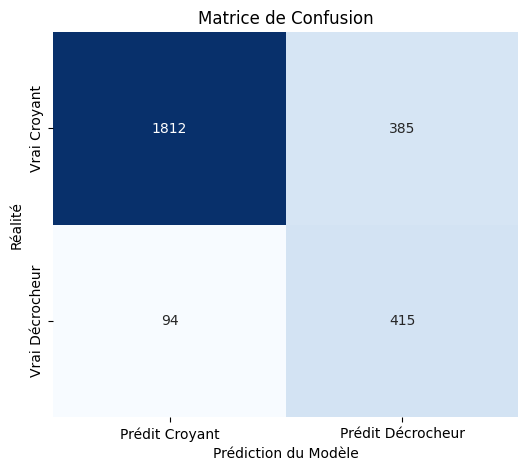

In [92]:
# =============================================================================
# 3. MODÉLISATION XGBOOST (Avec Correction du Déséquilibre)
# =============================================================================

# A. CALCUL DU RATIO DE DÉSÉQUILIBRE
# Combien de Croyants (0) pour chaque Décrocheur (1) ?
num_croyants = (y == 0).sum()
num_decrocheurs = (y == 1).sum()
scale_ratio = num_croyants / num_decrocheurs

print(f"⚖️ Balance des classes : {num_croyants} Croyants vs {num_decrocheurs} Décrocheurs")
print(f"⚖️ Facteur de correction (scale_pos_weight) : {scale_ratio:.2f}")
print("(Le modèle va 'sur-pondérer' les Décrocheurs pour compenser leur rareté)")

# B. DÉCOUPAGE STRATIFIÉ (On garde les proportions dans le test)
X_train, X_test, y_train, y_test = train_test_split(X_imputed_train, y, test_size=0.2, random_state=42, stratify=y)

# C. CONFIGURATION DU MODÈLE AVEC PONDÉRATION
model = xgb.XGBClassifier(
    n_estimators=300, 
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    
    # --- LA LIGNE MAGIQUE ---
    scale_pos_weight=scale_ratio,  # Force le focus sur la minorité
    # ------------------------
    
    use_label_encoder=False, 
    eval_metric='logloss',  # Ou 'auc' qui est mieux pour les déséquilibres
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Modèle entraîné (sensible à la minorité).")

# =============================================================================
# Evaluation
# =============================================================================

print("\n=========================================================")
print("📊 PHASE DE TEST : PERFORMANCE DU MODÈLE")
print("=========================================================")

# 1. Faire les prédictions sur le jeu de test (20% des données)
# y_pred : La décision finale (0 ou 1)
# y_prob : La probabilité (score de confiance)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

# 2. Le Rapport de Classification (Crucial pour les déséquilibres)
print("\n--- RAPPORT DÉTAILLÉ ---")
print(classification_report(y_test, y_pred, target_names=['Croyants (0)', 'Décrocheurs (1)']))

# 3. Score AUC (Capacité globale à séparer les deux camps)
auc = roc_auc_score(y_test, y_prob)
print(f"⭐ Score AUC-ROC : {auc:.4f}")

# 4. Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prédit Croyant', 'Prédit Décrocheur'],
            yticklabels=['Vrai Croyant', 'Vrai Décrocheur'])
plt.title('Matrice de Confusion')
plt.ylabel('Réalité')
plt.xlabel('Prédiction du Modèle')
plt.show()


💡 Phase 3 : Calcul des valeurs SHAP


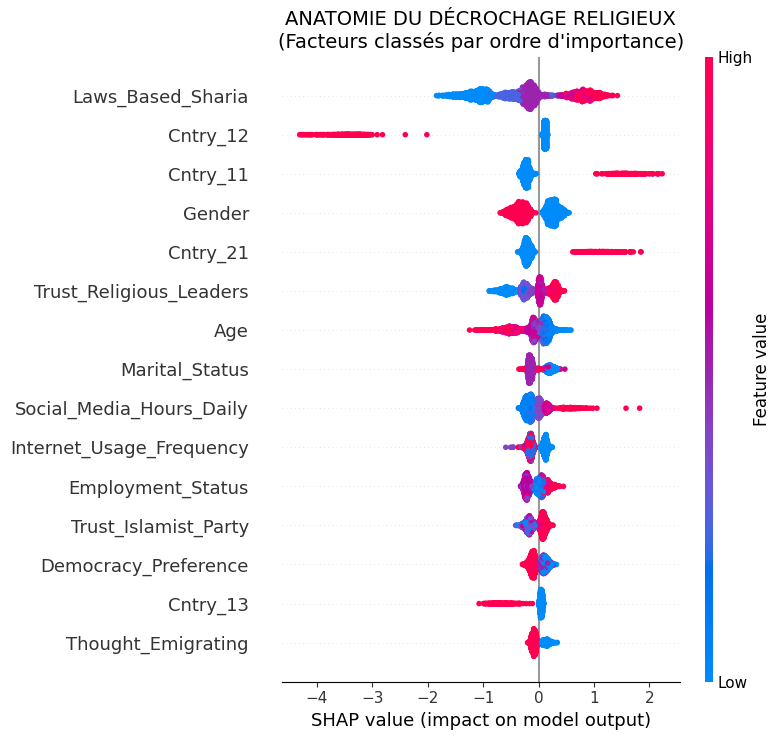


🏆 TOP 10 DES FACTEURS QUI POUSSENT À L'ATHÉISME :
                 Feature  Impact_SHAP
       Laws_Based_Sharia     0.646138
                Cntry_12     0.558824
                Cntry_11     0.323692
                  Gender     0.304234
                Cntry_21     0.295373
 Trust_Religious_Leaders     0.263507
                     Age     0.206395
          Marital_Status     0.167588
Social_Media_Hours_Daily     0.159333
Internet_Usage_Frequency     0.143689
       Employment_Status     0.137717
    Trust_Islamist_Party     0.127880
    Democracy_Preference     0.116775
                Cntry_13     0.105347
      Thought_Emigrating     0.101595

(Note : Impact_SHAP élevé = Variable très discriminante entre Croyants et Décrocheurs)


In [93]:
# =============================================================================
# 4. EXPLICABILITÉ SHAP (Le "Pourquoi")
# =============================================================================
print("\n💡 Phase 3 : Calcul des valeurs SHAP")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# A. VISUALISATION
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, show=False, max_display=15)
plt.title("ANATOMIE DU DÉCROCHAGE RELIGIEUX\n(Facteurs classés par ordre d'importance)", fontsize=14)
plt.tight_layout()
plt.show()

# B. CLASSEMENT TEXTUEL
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['Feature','Impact_SHAP'])
feature_importance.sort_values(by=['Impact_SHAP'], ascending=False, inplace=True)

print("\n🏆 TOP 10 DES FACTEURS QUI POUSSENT À L'ATHÉISME :")
print(feature_importance.head(15).to_string(index=False))

print("\n(Note : Impact_SHAP élevé = Variable très discriminante entre Croyants et Décrocheurs)")

##### **Ce chiffre de 385 Faux Positifs (des Croyants prédits Décrocheurs) n'est pas une erreur du modèle, c'est une découverte sociologique.**

##### **Ces 385 personnes sont officiellement "Croyantes" dans vos données, mais elles ont toutes les caractéristiques statistiques des "Décrocheurs". Hypothèse forte : Ce sont probablement des "Croyants non-pratiquants" ou des "Modérés" qui se sont déclarés Croyants par défaut.**

##### **Votre stratégie de "Zone Grise" (Seuil 0.40 - 0.60) va justement permettre de récupérer ces profils ambigus dans les données manquantes au lieu de les classer faussement comme "Décrocheurs radicaux".**

In [94]:
df_d3 = df_ready_for_imputation.copy()

# A. FILTRAGE DE LA CIBLE (2 uniquement)
# On garde uniquement les 2 (Modérés)
df_d3 = df_d3[df_d3['Religious_Self_Description'] == 2].copy()

# On retire la variable cible pour ne garder que les features
X2 = df_d3.drop(columns=['Religious_Self_Description'])

# Conversion des booléens en entiers 
bool_cols = X2.select_dtypes(include='bool').columns
X2[bool_cols] = X2[bool_cols].astype(int)

# On s'assure de ne garder que les colonnes numériques/encodées
X2 = X2.select_dtypes(include=[np.number])

print(f"📊 Dataset 'Modérés' prêt : {X2.shape[0]} individus, {X2.shape[1]} variables explicatives.")


# =============================================================================
# 2. IMPUTATION KNN (Les "Jumeaux Statistiques")
# =============================================================================

# A. SCALING GLOBAL 
scaler_modere = MinMaxScaler()

# fit_transform renvoie un array numpy, on le remet en DataFrame pour garder les noms de colonnes
X_scaled_array_modere = scaler_modere.fit_transform(X2)
X_scaled_modere = pd.DataFrame(X_scaled_array_modere, columns=X2.columns, index=X2.index)

# B. IMPUTATION
# On cherche les 4 voisins les plus proches pour deviner les valeurs manquantes
imputer_modere = KNNImputer(n_neighbors=4)

# L'imputer travaille sur les données scalées
X_imputed_array_modere = imputer_modere.fit_transform(X_scaled_modere)

# On remet en DataFrame (toujours scalé ici)
X_imputed_modere = pd.DataFrame(X_imputed_array_modere, columns=X2.columns, index=X2.index)

print("✅ Imputation terminée. Matrice complète à 100%.")
print(f"Vérification valeurs nulles restantes : {X_imputed_modere.isna().sum().sum()}")

📊 Dataset 'Modérés' prêt : 10586 individus, 33 variables explicatives.
✅ Imputation terminée. Matrice complète à 100%.
Vérification valeurs nulles restantes : 0


In [95]:
# les vraies valeurs (âge réel, etc.) pour l'analyse :
#X_final_moderes = pd.DataFrame(scaler.inverse_transform(X_imputed), columns=X2.columns, index=X2.index)


In [96]:
# =============================================================================
# ÉTAPE 3 : PRÉDICTION DES INCONNUS 
# =============================================================================
print("\n--- 3. Imputation DES INCONNUS ---")
df_nulls = df_ready_for_imputation.copy()
df_nulls = df_nulls[df_nulls['Religious_Self_Description'].isna()].copy()
X_nulls = df_nulls.drop(columns=['Religious_Self_Description'])

# Conversion types
X_nulls[bool_cols] = X_nulls[bool_cols].astype(int)
X_nulls = X_nulls.select_dtypes(include=[np.number])
# Alignement des colonnes (sécurité)
X_nulls = X_nulls[X.columns] 

# on tilise le scaler utilisé lors du training du modèle
X_nulls_scaled = pd.DataFrame(scaler.transform(X_nulls), columns=X_nulls.columns, index=X_nulls.index)
X_nulls_imputed = pd.DataFrame(imputer.transform(X_nulls_scaled), columns=X_nulls.columns, index=X_nulls.index)


--- 3. Imputation DES INCONNUS ---


In [97]:
print(X_nulls_imputed.shape)
X_nulls_imputed.head(5)

(2038, 33)


,Age,Gender,Education_Level,Marital_Status,Settlement_Type,Income_Covers_Expenses,Employment_Status,Future_Economic_Situation,Rich_Poor_Gap_Problem,Trust_Religious_Leaders,Trust_Islamist_Party,Trust_Government,Corruption_State_Agencies,Laws_Based_Sharia,Men_Better_Political_Leadership,Democracy_Preference,Freedom_Express_Opinion,Violence_Against_Women_Change,Internet_Usage_Frequency,Social_Media_Hours_Daily,Thought_Emigrating,Cntry_1,Cntry_5,Cntry_7,Cntry_8,Cntry_9,Cntry_10,Cntry_11,Cntry_12,Cntry_13,Cntry_15,Cntry_19,Cntry_21
28,0.000000,1.0,0.333333,0.0,0.5,1.000000,0.500000,0.50,0.666667,0.333333,1.000000,0.333333,0.000000,1.0000,0.666667,0.00,1.000000,0.333333,0.6,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
57,0.666667,0.0,0.500000,0.5,0.0,1.000000,0.333333,0.25,0.000000,1.000000,1.000000,1.000000,0.000000,0.5000,0.666667,1.00,0.333333,0.333333,0.2,0.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68,0.210526,1.0,0.833333,0.5,0.5,0.333333,0.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.333333,0.5000,1.000000,0.50,0.666667,0.000000,0.0,0.5000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
293,0.684211,1.0,0.166667,0.5,0.0,1.000000,0.500000,1.00,1.000000,0.666667,0.333333,0.666667,0.333333,0.4375,0.666667,0.75,0.000000,0.000000,1.0,0.1875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
325,0.894737,0.0,0.666667,0.5,0.0,0.666667,0.333333,0.25,0.000000,1.000000,1.000000,0.666667,0.000000,0.6250,0.666667,0.50,0.333333,0.000000,1.0,0.2500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [98]:
# B. PRÉDICTION AVEC lE MODÈLE XGBOOST
probs = model.predict_proba(X_nulls_imputed)[:, 1] # Proba d'être Classe 3 (target 1 vs 3)

def classer_incertitude(p):
    if p > 0.60: return 3   # Décrocheur
    elif p < 0.40: return 1 # Croyant
    else: return 2          # Modéré/Incertain

pred_classes = [classer_incertitude(p) for p in probs]

In [99]:
len(pred_classes)

2038

In [ ]:
X_imputed_train   X_imputed_modere   X_nulls_imputed

In [101]:
# =============================================================================
# 1. FINALISATION DU GROUPE TRAIN (Classes 1 & 3)
# =============================================================================
# Retour aux valeurs réelles 
X_train_final_array = scaler.inverse_transform(X_imputed_train) # X_imputed du bloc 1
df_train_final = pd.DataFrame(X_train_final_array, columns=X.columns, index=X.index)

# On réintègre la cible (Target)
df_train_final['Religious_Self_Description'] = y.map({0: 1, 1: 3}) 

# =============================================================================
# 2. FINALISATION DU GROUPE MODÉRÉS (Classe 2)
# =============================================================================
X_mod_final_array = scaler_modere.inverse_transform(X_imputed_modere) # X_imputed du bloc 2
df_mod_final = pd.DataFrame(X_mod_final_array, columns=X2.columns, index=X2.index)

# On réintègre la cible (On sait que c'est 2)
df_mod_final['Religious_Self_Description'] = 2

# =============================================================================
# 3. LE GROUPE DES NULLS 
# =============================================================================
X_nulls_final = pd.DataFrame(scaler.inverse_transform(X_nulls_imputed), columns=X_nulls.columns, index=X_nulls.index)
df_nulls_final = X_nulls_final.copy()
df_nulls_final['Religious_Self_Description'] = pred_classes # On assigne la prédiction

df_nulls_final = df_nulls_final[df_train_final.columns]

# =============================================================================
# 4. LA GRANDE FUSION (CONCATÉNATION)
# =============================================================================

# Vérification de sécurité : Les colonnes sont-elles identiques ?
cols_ref = list(df_train_final.columns)
df_mod_final = df_mod_final[cols_ref]
df_nulls_final = df_nulls_final[cols_ref]

# Fusion
df_global_complet = pd.concat([df_train_final, df_mod_final, df_nulls_final], axis=0)

In [102]:
print(df_global_complet.shape)
df_global_complet.head()

(26154, 34)


,Age,Gender,Education_Level,Marital_Status,Settlement_Type,Income_Covers_Expenses,Employment_Status,Future_Economic_Situation,Rich_Poor_Gap_Problem,Trust_Religious_Leaders,Trust_Islamist_Party,Trust_Government,Corruption_State_Agencies,Laws_Based_Sharia,Men_Better_Political_Leadership,Democracy_Preference,Freedom_Express_Opinion,Violence_Against_Women_Change,Internet_Usage_Frequency,Social_Media_Hours_Daily,Thought_Emigrating,Cntry_1,Cntry_5,Cntry_7,Cntry_8,Cntry_9,Cntry_10,Cntry_11,Cntry_12,Cntry_13,Cntry_15,Cntry_19,Cntry_21,Religious_Self_Description
0,23.0,1.0,3.0,1.0,2.0,3.0,6.0,3.0,2.0,4.0,4.0,3.0,1.0,5.0,1.0,3.0,4.0,2.00,2.0,2.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
1,60.0,1.0,4.0,4.0,2.0,3.0,3.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,1.25,1.0,2.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,50.0,1.0,2.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,4.0,2.0,1.0,3.0,2.5,3.0,2.0,2.00,1.0,2.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,54.0,1.0,2.0,4.0,1.0,4.0,7.0,1.0,2.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,3.0,1.00,6.0,2.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
5,72.0,2.0,1.0,7.0,1.0,2.0,4.0,1.0,1.0,4.0,4.0,3.0,1.0,4.5,2.0,3.0,2.0,1.50,6.0,2.25,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [104]:
df_global_complet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26154 entries, 0 to 26141
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              26154 non-null  float64
 1   Gender                           26154 non-null  float64
 2   Education_Level                  26154 non-null  float64
 3   Marital_Status                   26154 non-null  float64
 4   Settlement_Type                  26154 non-null  float64
 5   Income_Covers_Expenses           26154 non-null  float64
 6   Employment_Status                26154 non-null  float64
 7   Future_Economic_Situation        26154 non-null  float64
 8   Rich_Poor_Gap_Problem            26154 non-null  float64
 9   Trust_Religious_Leaders          26154 non-null  float64
 10  Trust_Islamist_Party             26154 non-null  float64
 11  Trust_Government                 26154 non-null  float64
 12  Corruption_State_Agenci

In [105]:
# =============================================================================
# 5. NETTOYAGE FINAL (Rounding)
# =============================================================================
# Le KNN génère des décimales (ex: Opinion 1 devient 1.2).
# Scientifiquement, pour des échelles ordinales (1-10) ou l'âge, on veut souvent des entiers.
# Liste des colonnes à ne PAS arrondir (ex: si vous avez des ratios précis)
# Sinon, on arrondit tout sauf peut-être des index spécifiques.
cols_to_round = [c for c in df_global_complet.columns if c != 'Religious_Self_Description']

# On arrondit à 0 décimale (entier le plus proche)
df_global_complet[cols_to_round] = df_global_complet[cols_to_round].round(0)

print(f"✅ FUSION RÉUSSIE.")
print(f"Taille totale : {len(df_global_complet)} lignes.")
print("Répartition finale de la variable cible :")
print(df_global_complet['Religious_Self_Description'].value_counts())

# Vérification finale des Nulls
nb_nulls = df_global_complet.isna().sum().sum()
print(f"Nombre total de valeurs manquantes restantes : {nb_nulls}")

✅ FUSION RÉUSSIE.
Taille totale : 26154 lignes.
Répartition finale de la variable cible :
Religious_Self_Description
1    12020
2    10901
3     3233
Name: count, dtype: int64
Nombre total de valeurs manquantes restantes : 0


In [106]:
df_global_complet.head()

,Age,Gender,Education_Level,Marital_Status,Settlement_Type,Income_Covers_Expenses,Employment_Status,Future_Economic_Situation,Rich_Poor_Gap_Problem,Trust_Religious_Leaders,Trust_Islamist_Party,Trust_Government,Corruption_State_Agencies,Laws_Based_Sharia,Men_Better_Political_Leadership,Democracy_Preference,Freedom_Express_Opinion,Violence_Against_Women_Change,Internet_Usage_Frequency,Social_Media_Hours_Daily,Thought_Emigrating,Cntry_1,Cntry_5,Cntry_7,Cntry_8,Cntry_9,Cntry_10,Cntry_11,Cntry_12,Cntry_13,Cntry_15,Cntry_19,Cntry_21,Religious_Self_Description
0,23.0,1.0,3.0,1.0,2.0,3.0,6.0,3.0,2.0,4.0,4.0,3.0,1.0,5.0,1.0,3.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
1,60.0,1.0,4.0,4.0,2.0,3.0,3.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,50.0,1.0,2.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,4.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,54.0,1.0,2.0,4.0,1.0,4.0,7.0,1.0,2.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,3.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
5,72.0,2.0,1.0,7.0,1.0,2.0,4.0,1.0,1.0,4.0,4.0,3.0,1.0,4.0,2.0,3.0,2.0,2.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [110]:
df_global_complet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26154 entries, 0 to 26141
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              26154 non-null  float64
 1   Gender                           26154 non-null  float64
 2   Education_Level                  26154 non-null  float64
 3   Marital_Status                   26154 non-null  float64
 4   Settlement_Type                  26154 non-null  float64
 5   Income_Covers_Expenses           26154 non-null  float64
 6   Employment_Status                26154 non-null  float64
 7   Future_Economic_Situation        26154 non-null  float64
 8   Rich_Poor_Gap_Problem            26154 non-null  float64
 9   Trust_Religious_Leaders          26154 non-null  float64
 10  Trust_Islamist_Party             26154 non-null  float64
 11  Trust_Government                 26154 non-null  float64
 12  Corruption_State_Agenci

In [107]:
import os

output_dir = '/home/chahiri/repos/data_mining_pr/'
os.makedirs(output_dir, exist_ok=True)
df_global_complet.to_csv(os.path.join(output_dir, 'df_global_complet.csv'), index=False)

#### **L'Insight à chercher : Est-ce que les "Modérés" sont simplement des "Croyants light" (même forme mais plus petite) ou ont-ils des valeurs totalement différentes ?**

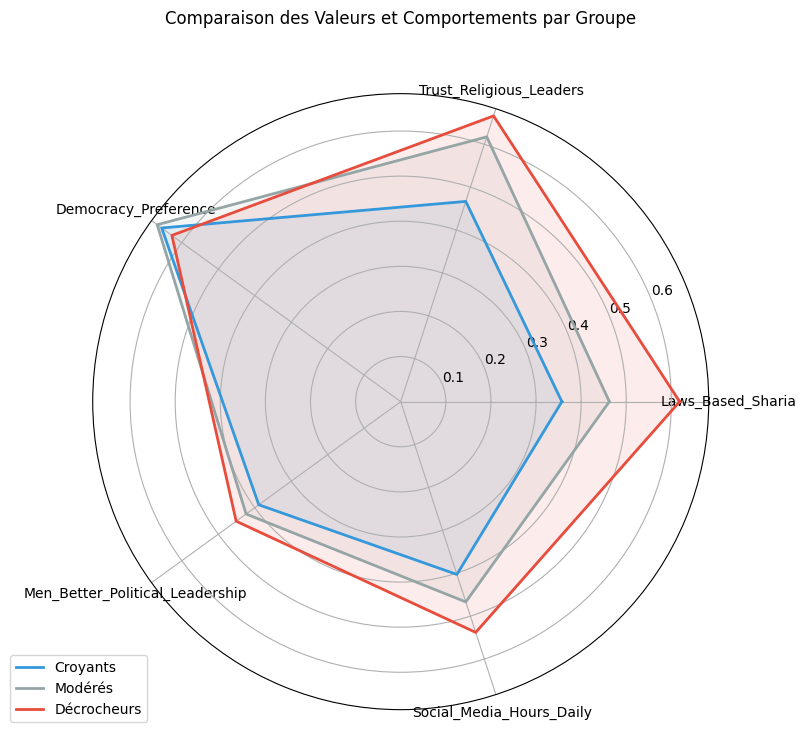

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Préparation des données pour le Radar Chart
# On sélectionne les colonnes de "Valeurs" (Opinions)
features_radar = ['Laws_Based_Sharia', 'Trust_Religious_Leaders', 
                  'Democracy_Preference', 'Men_Better_Political_Leadership', 
                  'Social_Media_Hours_Daily']

# On normalise tout entre 0 et 1 pour que le graphique soit lisible
scaler = MinMaxScaler()
df_radar = df_global_complet.copy()
df_radar[features_radar] = scaler.fit_transform(df_radar[features_radar])

# On calcule la moyenne par groupe
means = df_radar.groupby('Religious_Self_Description')[features_radar].mean()

# 2. Construction du Radar Chart
categories = list(features_radar)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Fermer le cercle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Définition des labels et couleurs
labels_map = {1: "Croyants", 2: "Modérés", 3: "Décrocheurs"}
colors = ["#3498db", "#95a5a6", "#e74c3c"] # Bleu, Gris, Rouge

for i, (idx, row) in enumerate(means.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels_map[idx], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title("Comparaison des Valeurs et Comportements par Groupe", y=1.1)
plt.show()

### **L'Insight à chercher : Le décrochage est-il lié à une surconsommation d'internet ?**

### **Regardez si la boîte rouge (Décrocheurs) est nettement plus haute que la bleue sur l'usage des réseaux sociaux.**

### **Regardez si les Modérés sont "connectés comme des jeunes" ou "déconnectés comme des anciens".**

/tmp/ipykernel_67187/4132051179.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Religious_Self_Description', y='Social_Media_Hours_Daily', data=df_global_complet,


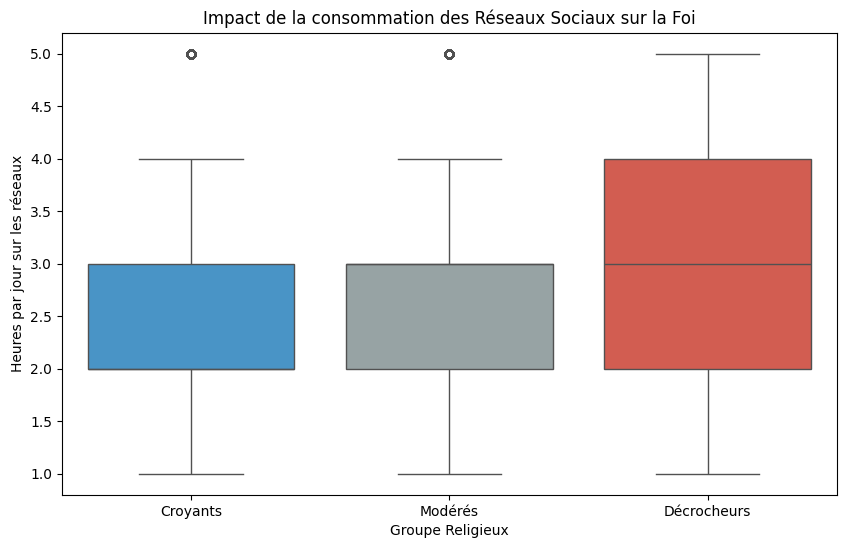

In [111]:
plt.figure(figsize=(10, 6))
# On utilise les données brutes (non normalisées) pour avoir les vraies heures
sns.boxplot(x='Religious_Self_Description', y='Social_Media_Hours_Daily', data=df_global_complet, 
            palette={'1': "#3498db", '2': "#95a5a6", '3': "#e74c3c"})

plt.xticks([0, 1, 2], ['Croyants', 'Modérés', 'Décrocheurs'])
plt.title("Impact de la consommation des Réseaux Sociaux sur la Foi")
plt.ylabel("Heures par jour sur les réseaux")
plt.xlabel("Groupe Religieux")
plt.show()

#### **3. La Dynamique Générationnelle (KDE Plot)**
#### **L'âge est classique, mais la visualisation en densité (KDE) est plus fine qu'une moyenne.**

#### **L'Insight à chercher : Y a-t-il une "bosse" spécifique ?**

#### **Si les Décrocheurs ont un pic vers 20-25 ans et que les Croyants sont plats, c'est un effet de génération.**

#### **Si les courbes se superposent, alors le phénomène touche tous les âges (ce qui serait une découverte surprenante).**

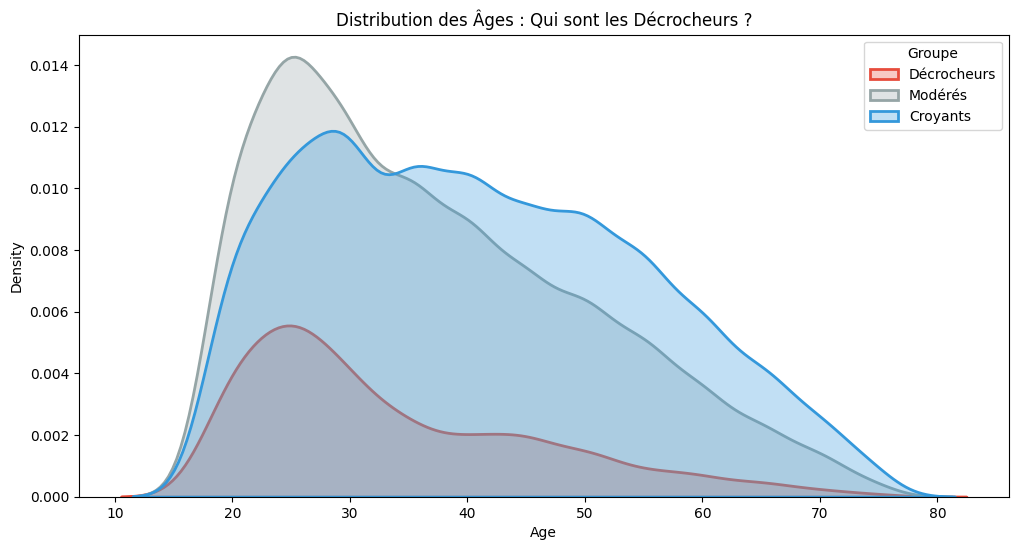

In [112]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_global_complet, x='Age', hue='Religious_Self_Description', fill=True,
            palette={1: "#3498db", 2: "#95a5a6", 3: "#e74c3c"}, alpha=0.3, linewidth=2)

plt.legend(title='Groupe', labels=['Décrocheurs', 'Modérés', 'Croyants'])
plt.title("Distribution des Âges : Qui sont les Décrocheurs ?")
plt.show()

#### **4. Le Positionnement des "Nouveaux Modérés"**
#### **Puisque vous avez imputé cette classe, il est crucial de vérifier sa cohérence.**

#### **L'Insight à chercher : Sur la question centrale de la Sharia (Loi divine vs Loi civile), où se placent-ils ?**

#### **Sont-ils à mi-chemin (moyenne = 3.5/7) ?**

#### **Ou rejettent-ils la Sharia autant que les Décrocheurs ?**

/tmp/ipykernel_67187/3331500650.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Religious_Self_Description', y='Laws_Based_Sharia', data=df_global_complet,


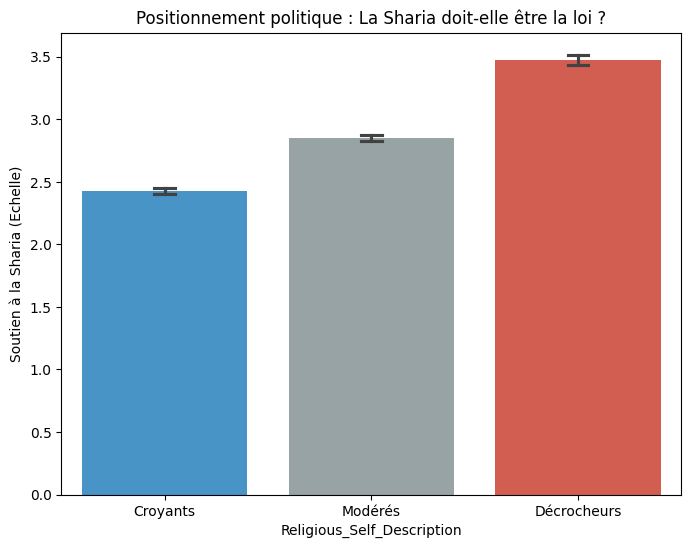

In [114]:
# Barplot avec intervalle de confiance
plt.figure(figsize=(8, 6))
sns.barplot(x='Religious_Self_Description', y='Laws_Based_Sharia', data=df_global_complet,
            palette={'1': "#3498db", '2': "#95a5a6", '3': "#e74c3c"}, capsize=.1)

plt.xticks([0, 1, 2], ['Croyants', 'Modérés', 'Décrocheurs'])
plt.ylabel("Soutien à la Sharia (Echelle)")
plt.title("Positionnement politique : La Sharia doit-elle être la loi ?")
plt.show()

In [ ]:
# Barplot avec intervalle de confiance
plt.figure(figsize=(8, 6))
sns.barplot(x='Religious_Self_Description', y='Laws_Based_Sharia', data=df_global_complet,
            palette={'1': "#3498db", '2': "#95a5a6", '3': "#e74c3c"}, capsize=.1)

plt.xticks([0, 1, 2], ['Croyants', 'Modérés', 'Décrocheurs'])
plt.ylabel("Soutien à la Sharia (Echelle)")
plt.title("Positionnement politique : La Sharia doit-elle être la loi ?")
plt.show()

In [ ]:
print('')